In [14]:
## Used Code From https://www.kaggle.com/code/timgoodfellow/nsl-kdd-explorations to get NSL-KDD setup

In [15]:
import ipyparallel as ipp
n = 4
rc = ipp.Cluster(engines="mpi", n=n).start_and_connect_sync()
view = rc[:]
rc.ids

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

[0, 1, 2, 3]

In [16]:
%%px --block
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpi4py import MPI
np.random.seed(482)

mpi = MPI.COMM_WORLD
bcast = mpi.bcast
barrier = mpi.barrier
rank = mpi.rank
size = mpi.size
print("MPI rank: %i/%i" % (mpi.rank, mpi.size))

[stdout:0] MPI rank: 0/4


[stdout:1] MPI rank: 1/4


[stdout:2] MPI rank: 2/4


[stdout:3] MPI rank: 3/4


## Helper Functions

In [17]:
%%px --block
# Implement Custom Loss Function
@tf.function
def consensus_loss(y_true, y_pred, z, l2, iB):

    if iB:
        # local error
        local_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
        # consensus loss error
        consensus_loss = l2*tf.keras.losses.BinaryCrossentropy()(z, y_pred)
    else:
        # local error
        local_loss = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
        # consensus error
        consensus_loss = tf.keras.losses.CategoricalCrossentropy()(z, y_pred)
        
    return local_loss + consensus_loss

In [18]:
 %%px --block
# Play around with this more
def set_learning_rate1(optimizer, epoch):
    if epoch <= 30:
        optimizer.lr = 0.0025
    if 30 < epoch <= 100:
        optimizer.lr = 0.0015
    elif 100 < epoch <= 200:
        optimizer.lr = 0.001
    elif 200 < epoch <= 300:
        optimizer.lr = 0.0005
    elif 300 < epoch <= 400:
        optimizer.lr = 0.00045
    elif 400 < epoch <= 450:
        optimizer.lr = 0.00005
    else:
        optimizer.lr = 0.00001

In [19]:
 %%px --block
# Play around with this more
def set_learning_rate2(optimizer, epoch):
    if epoch >= 1:
        optimizer.lr = optimizer.lr * tf.math.exp(-0.1)

In [20]:
%%px --block
def data_pre_process(rank, size, coordination_size, coord_bs, train_bs):

    def map_attack(attack):

        # attack classifications
        dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable',
                       'smurf','teardrop','udpstorm','worm']
        u2r_attacks = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
        r2l_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop',
                          'named','phf','sendmail','snmpgetattack','snmpguess','spy',
                          'warezclient','warezmaster','xclock','xsnoop']
        probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']

        if attack in dos_attacks:
            # dos_attacks map to 1
            attack_type = 1
        elif attack in r2l_attacks:
            # remote access attacks map to 2
            attack_type = 2
        elif attack in u2r_attacks:
            # privilege escalation attacks map to 3
            attack_type = 3
        elif attack in probe_attacks:
            # probe_attacks mapt to 4
            attack_type = 4
        else:
            # normal maps to 0
            attack_type = 0
        return attack_type

    # load data with column names
    colnames = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
            'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
            'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
            'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
            'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
            'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
            'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
            'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
            'dst_host_srv_rerror_rate', 'attack_type', 'level']
    train_df = pd.read_csv("Data/KDDTrain+.txt", names=colnames, sep=",")
    test_df = pd.read_csv("Data/KDDTest+.txt", names=colnames, sep=",")

    # make all floats 32 (for tensorflow memory purposes)
    train_df[train_df.select_dtypes(np.float64).columns] = train_df.select_dtypes(np.float64).astype(np.float32)
    test_df[test_df.select_dtypes(np.float64).columns] = test_df.select_dtypes(np.float64).astype(np.float32)

    # Create an attack flag: map normal behavior to 0, all attacks to 1
    is_attack_train = train_df.attack_type.map(lambda a: 0 if a == 'normal' else 1)
    is_attack_test = test_df.attack_type.map(lambda a: 0 if a == 'normal' else 1)
    train_df['attack_flag'] = is_attack_train
    test_df['attack_flag'] = is_attack_test

    attack_labels = ['Normal','DoS','R2L', 'U2R','Probe']

    # map the data and join to the data set
    attack_map = train_df.attack_type.apply(map_attack)
    train_df['attack_map'] = attack_map

    test_attack_map = test_df.attack_type.apply(map_attack)
    test_df['attack_map'] = test_attack_map

    onehot_features = ['protocol_type', 'service', 'flag']
    other_features = ['duration', 'src_bytes', 'dst_bytes', 'land',
                'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
                'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
                'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
                'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
                'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
                'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
                'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
                'dst_host_srv_rerror_rate', 'level']
    train_onehot = pd.get_dummies(train_df[onehot_features])
    test_onehot = pd.get_dummies(test_df[onehot_features])

    test_index = np.arange(len(test_df.index))
    column_diffs = list(set(train_onehot.columns.values)-set(test_onehot.columns.values))
    diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)
    column_order = train_onehot.columns.to_list()
    test_temp = test_onehot.join(diff_df)
    test_final = test_temp[column_order].fillna(0)

    test_set = test_final.join(test_df[other_features])
    train_set = train_onehot.join(train_df[other_features])

    train_set_norm = train_set.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    test_set_norm = test_set.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    train_set_norm = train_set_norm.fillna(0)
    test_set_norm = test_set_norm.fillna(0)
    num_inputs = len(train_set.columns.to_list())
    num_outputs_multi = len(attack_labels)

    # split train into a coordination set
    coord_set = train_set_norm.iloc[:coordination_size,:]
    whole_train_set = train_set_norm.iloc[coordination_size:,:]

    # test labels
    test_binary_y = tf.convert_to_tensor(test_df['attack_flag'])
    test_multi_y = tf.convert_to_tensor(test_df['attack_map'].to_list())

    # Split training data amongst workers
    worker_train_set_norm = np.array_split(whole_train_set, size)[rank]

    # create our train labels
    train_attack_map_list_binary = train_df['attack_flag'].to_list()
    train_attack_map_list_multi = train_df['attack_map'].to_list()

    # split coordination set labels
    coordination_binary_y = tf.convert_to_tensor(train_attack_map_list_binary[:coordination_size])
    coordination_multi_y = tf.convert_to_tensor(train_attack_map_list_multi[:coordination_size])
    whole_train_label_b = train_attack_map_list_binary[coordination_size:]
    whole_train_label_m = train_attack_map_list_multi[coordination_size:]

    worker_train_label_binary = np.array_split(whole_train_label_b, size)[rank]
    worker_train_label_multi = np.array_split(whole_train_label_m, size)[rank]
    train_binary_y = tf.convert_to_tensor(worker_train_label_binary)
    train_multi_y = tf.convert_to_tensor(worker_train_label_multi)

    # make data into tensors
    train_set = tf.convert_to_tensor(worker_train_set_norm)
    test_set = tf.convert_to_tensor(test_set_norm)
    coordination_set = tf.convert_to_tensor(coord_set)
    
    # full train dataset and labels (for confusion matrix)
    train_data = tf.convert_to_tensor(train_set_norm)
    train_label_m = tf.convert_to_tensor(train_attack_map_list_multi)
    train_label_b = tf.convert_to_tensor(train_attack_map_list_binary)

    # create tensorflow dataset for test and train
    training_binary = tf.data.Dataset.from_tensor_slices((train_set, train_binary_y)).batch(train_bs)
    training_multi = tf.data.Dataset.from_tensor_slices((train_set, train_multi_y)).batch(train_bs)
    test_binary = tf.data.Dataset.from_tensor_slices((test_set, test_binary_y)).batch(train_bs)
    test_multi = tf.data.Dataset.from_tensor_slices((test_set, test_multi_y)).batch(train_bs)
    coordination_binary = tf.data.Dataset.from_tensor_slices((coordination_set,coordination_binary_y)).batch(coord_bs)
    coordination_multi = tf.data.Dataset.from_tensor_slices((coordination_set,coordination_multi_y)).batch(coord_bs)

    return training_binary, test_binary, coordination_binary, training_multi, test_multi, coordination_multi, \
           train_data, train_label_b, train_label_m, test_set, test_binary_y, test_multi_y, num_inputs, \
           num_outputs_multi

In [23]:
%%px --block
def train(model, rank, size, lossF, optimizer, train_dataset, coordination_dataset, epochs, 
          coord_batch_size, batches, num_outputs, isBinary):

    if isBinary:
        acc_metric = tf.keras.metrics.BinaryAccuracy()
        loss_metric = tf.keras.metrics.BinaryCrossentropy()
    else:
        acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()

    for epoch in range(epochs):

        # Adjust learning rate
        set_learning_rate2(optimizer, epoch)

        # Local Training
        for batch_idx, (data, target) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                y_p = model(data, training=True)
                loss_val = lossF(y_true=target, y_pred=y_p)
            grads = tape.gradient(loss_val, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            acc_metric.update_state(target, y_p)
            loss_metric.update_state(target, y_p)

        # Forward Pass of Coordination Set
        send_predicted = np.zeros((num_outputs*coord_batch_size, batches), dtype=np.float32)
        recv_avg_pred = np.zeros((num_outputs*coord_batch_size, batches), dtype=np.float32)
        for c_batch_idx, (c_data, c_target) in enumerate(coordination_dataset):
            pred = model(c_data, training=True)
            send_predicted[:, c_batch_idx] = pred.numpy().flatten()

        # Communication Process Here
        MPI.COMM_WORLD.Allreduce(send_predicted, recv_avg_pred, op=MPI.SUM)
        recv_avg_pred = recv_avg_pred/size

        # Consensus Training
        for c_batch_idx, (c_data, c_target) in enumerate(coordination_dataset):
            with tf.GradientTape() as tape:
                c_yp = model(c_data, training=True)
                loss_val = consensus_loss(y_true=c_target, y_pred=c_yp,
                                           z=recv_avg_pred[:, c_batch_idx].reshape(coord_batch_size, num_outputs),
                                           l2=0.1, iB=isBinary)
            grads = tape.gradient(loss_val, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # acc_metric.update_state(c_target, c_yp)
        print('(Rank %d) Training Accuracy for Epoch %d: %0.4f, Loss: %0.4f' % (rank, epoch, acc_metric.result(), \
                                                                                loss_metric.result()))
        acc_metric.reset_states()
        loss_metric.reset_states()

## Run Experiments

In [22]:
%%px --block
isBinary = True
epochs = 20
train_bs = 64
coord_bs = 32
coord_examples = 32*coord_bs
coord_num_batches = int(np.ceil(coord_examples/coord_bs))
train_data_b, test_data_b, coord_data_b, train_data_m, test_data_m, coord_data_m, train_data, train_label_b, \
train_label_m, test_data, test_label_b, test_label_m, num_inputs, num_outputs_multi =  \
data_pre_process(rank, size, coord_examples, coord_bs, train_bs)

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

In [24]:
%%px --block
# binary classification model
if rank == 0 or rank == 1:
    binary_model = tf.keras.Sequential()
    binary_model.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(num_inputs,)))
    binary_model.add(tf.keras.layers.Dense(256, activation='relu'))
    binary_model.add(tf.keras.layers.Dense(128, activation='relu'))
    binary_model.add(tf.keras.layers.Dense(64, activation='relu'))
    binary_model.add(tf.keras.layers.Dense(10, activation='relu'))
    binary_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
else: 
    binary_model = tf.keras.Sequential()
    binary_model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(num_inputs,)))
    binary_model.add(tf.keras.layers.Dense(128, activation='relu'))
    binary_model.add(tf.keras.layers.Dense(128, activation='relu'))
    binary_model.add(tf.keras.layers.Dense(64, activation='relu'))
    binary_model.add(tf.keras.layers.Dense(32, activation='relu'))
    binary_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Initialize Local Loss Function
lossF = tf.keras.losses.BinaryCrossentropy()

# Initialize Optimizer
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [25]:
%%px --block
train(binary_model, rank, size, lossF, optimizer, train_data_b, coord_data_b, 
      epochs, coord_bs, coord_num_batches, 1, isBinary)

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:3] (Rank 3) Training Accuracy for Epoch 0: 0.9860, Loss: 0.0451
(Rank 3) Training Accuracy for Epoch 1: 0.9943, Loss: 0.0168
(Rank 3) Training Accuracy for Epoch 2: 0.9950, Loss: 0.0155
(Rank 3) Training Accuracy for Epoch 3: 0.9951, Loss: 0.0126
(Rank 3) Training Accuracy for Epoch 4: 0.9958, Loss: 0.0132
(Rank 3) Training Accuracy for Epoch 5: 0.9968, Loss: 0.0087
(Rank 3) Training Accuracy for Epoch 6: 0.9972, Loss: 0.0078
(Rank 3) Training Accuracy for Epoch 7: 0.9972, Loss: 0.0096
(Rank 3) Training Accuracy for Epoch 8: 0.9978, Loss: 0.0068
(Rank 3) Training Accuracy for Epoch 9: 0.9978, Loss: 0.0060
(Rank 3) Training Accuracy for Epoch 10: 0.9976, Loss: 0.0063
(Rank 3) Training Accuracy for Epoch 11: 0.9979, Loss: 0.0066
(Rank 3) Training Accuracy for Epoch 12: 0.9980, Loss: 0.0054
(Rank 3) Training Accuracy for Epoch 13: 0.9985, Loss: 0.0043
(Rank 3) Training Accuracy for Epoch 14: 0.9983, Loss: 0.0043
(Rank 3) Training Accuracy for Epoch 15: 0.9986, Loss: 0.0041
(Rank 3

[stdout:2] (Rank 2) Training Accuracy for Epoch 0: 0.9850, Loss: 0.0475
(Rank 2) Training Accuracy for Epoch 1: 0.9937, Loss: 0.0213
(Rank 2) Training Accuracy for Epoch 2: 0.9950, Loss: 0.0156
(Rank 2) Training Accuracy for Epoch 3: 0.9958, Loss: 0.0129
(Rank 2) Training Accuracy for Epoch 4: 0.9965, Loss: 0.0095
(Rank 2) Training Accuracy for Epoch 5: 0.9975, Loss: 0.0068
(Rank 2) Training Accuracy for Epoch 6: 0.9971, Loss: 0.0086
(Rank 2) Training Accuracy for Epoch 7: 0.9979, Loss: 0.0059
(Rank 2) Training Accuracy for Epoch 8: 0.9976, Loss: 0.0074
(Rank 2) Training Accuracy for Epoch 9: 0.9982, Loss: 0.0049
(Rank 2) Training Accuracy for Epoch 10: 0.9982, Loss: 0.0050
(Rank 2) Training Accuracy for Epoch 11: 0.9985, Loss: 0.0038
(Rank 2) Training Accuracy for Epoch 12: 0.9985, Loss: 0.0039
(Rank 2) Training Accuracy for Epoch 13: 0.9988, Loss: 0.0035
(Rank 2) Training Accuracy for Epoch 14: 0.9987, Loss: 0.0048
(Rank 2) Training Accuracy for Epoch 15: 0.9989, Loss: 0.0029
(Rank 2

[stdout:1] (Rank 1) Training Accuracy for Epoch 0: 0.9836, Loss: 0.0469
(Rank 1) Training Accuracy for Epoch 1: 0.9932, Loss: 0.0195
(Rank 1) Training Accuracy for Epoch 2: 0.9945, Loss: 0.0158
(Rank 1) Training Accuracy for Epoch 3: 0.9962, Loss: 0.0108
(Rank 1) Training Accuracy for Epoch 4: 0.9961, Loss: 0.0104
(Rank 1) Training Accuracy for Epoch 5: 0.9970, Loss: 0.0087
(Rank 1) Training Accuracy for Epoch 6: 0.9968, Loss: 0.0095
(Rank 1) Training Accuracy for Epoch 7: 0.9970, Loss: 0.0074
(Rank 1) Training Accuracy for Epoch 8: 0.9974, Loss: 0.0067
(Rank 1) Training Accuracy for Epoch 9: 0.9977, Loss: 0.0066
(Rank 1) Training Accuracy for Epoch 10: 0.9977, Loss: 0.0059
(Rank 1) Training Accuracy for Epoch 11: 0.9976, Loss: 0.0065
(Rank 1) Training Accuracy for Epoch 12: 0.9979, Loss: 0.0052
(Rank 1) Training Accuracy for Epoch 13: 0.9982, Loss: 0.0047
(Rank 1) Training Accuracy for Epoch 14: 0.9983, Loss: 0.0048
(Rank 1) Training Accuracy for Epoch 15: 0.9982, Loss: 0.0040
(Rank 1

[stdout:0] (Rank 0) Training Accuracy for Epoch 0: 0.9840, Loss: 0.0490
(Rank 0) Training Accuracy for Epoch 1: 0.9924, Loss: 0.0224
(Rank 0) Training Accuracy for Epoch 2: 0.9930, Loss: 0.0174
(Rank 0) Training Accuracy for Epoch 3: 0.9953, Loss: 0.0124
(Rank 0) Training Accuracy for Epoch 4: 0.9952, Loss: 0.0136
(Rank 0) Training Accuracy for Epoch 5: 0.9963, Loss: 0.0091
(Rank 0) Training Accuracy for Epoch 6: 0.9968, Loss: 0.0078
(Rank 0) Training Accuracy for Epoch 7: 0.9973, Loss: 0.0064
(Rank 0) Training Accuracy for Epoch 8: 0.9973, Loss: 0.0064
(Rank 0) Training Accuracy for Epoch 9: 0.9976, Loss: 0.0064
(Rank 0) Training Accuracy for Epoch 10: 0.9974, Loss: 0.0067
(Rank 0) Training Accuracy for Epoch 11: 0.9978, Loss: 0.0052
(Rank 0) Training Accuracy for Epoch 12: 0.9979, Loss: 0.0052
(Rank 0) Training Accuracy for Epoch 13: 0.9984, Loss: 0.0043
(Rank 0) Training Accuracy for Epoch 14: 0.9987, Loss: 0.0032
(Rank 0) Training Accuracy for Epoch 15: 0.9987, Loss: 0.0033
(Rank 0

In [26]:
%%px --block
binary_model.compile(loss=lossF, optimizer=optimizer, metrics=[tf.keras.metrics.BinaryAccuracy()])
binary_model.evaluate(test_data_b)

[stdout:0] 353/353 [==============================] - 1s 2ms/step - loss: 5.0431 - binary_accuracy: 0.8189


[stdout:3] 353/353 [==============================] - 1s 2ms/step - loss: 6.0617 - binary_accuracy: 0.8249


[stdout:2] 353/353 [==============================] - 1s 2ms/step - loss: 5.2671 - binary_accuracy: 0.8155


[stdout:1] 353/353 [==============================] - 1s 2ms/step - loss: 4.8489 - binary_accuracy: 0.8309


Out[2:22]: [5.2670979499816895, 0.8155163526535034]

Out[3:22]: [6.061651706695557, 0.8249201774597168]

Out[1:22]: [4.84890604019165, 0.8308640718460083]

Out[0:22]: [5.043061256408691, 0.8188875317573547]

In [27]:
%%px --block
# multi classification model
multi_model = tf.keras.Sequential()
multi_model.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(num_inputs,)))
multi_model.add(tf.keras.layers.Dense(256, activation='relu'))
multi_model.add(tf.keras.layers.Dense(128, activation='relu'))
multi_model.add(tf.keras.layers.Dense(64, activation='relu'))
multi_model.add(tf.keras.layers.Dense(10, activation='relu'))
multi_model.add(tf.keras.layers.Dense(num_outputs_multi, activation='softmax'))

# Initialize Local Loss Function
lossF = tf.keras.losses.SparseCategoricalCrossentropy()

# Initialize Optimizer
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [28]:
%%px --block
isBinary = False
train(multi_model, rank, size, lossF, optimizer, train_data_m, 
      coord_data_m, epochs, coord_bs, coord_num_batches, num_outputs_multi, isBinary)

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:0] (Rank 0) Training Accuracy for Epoch 0: 0.9350, Loss: 0.1841
(Rank 0) Training Accuracy for Epoch 1: 0.9839, Loss: 0.0457
(Rank 0) Training Accuracy for Epoch 2: 0.9888, Loss: 0.0387
(Rank 0) Training Accuracy for Epoch 3: 0.9911, Loss: 0.0238
(Rank 0) Training Accuracy for Epoch 4: 0.9916, Loss: 0.0269
(Rank 0) Training Accuracy for Epoch 5: 0.9944, Loss: 0.0175
(Rank 0) Training Accuracy for Epoch 6: 0.9952, Loss: 0.0136
(Rank 0) Training Accuracy for Epoch 7: 0.9956, Loss: 0.0123
(Rank 0) Training Accuracy for Epoch 8: 0.9963, Loss: 0.0115
(Rank 0) Training Accuracy for Epoch 9: 0.9967, Loss: 0.0084
(Rank 0) Training Accuracy for Epoch 10: 0.9961, Loss: 0.0103
(Rank 0) Training Accuracy for Epoch 11: 0.9966, Loss: 0.0089
(Rank 0) Training Accuracy for Epoch 12: 0.9969, Loss: 0.0083
(Rank 0) Training Accuracy for Epoch 13: 0.9978, Loss: 0.0060
(Rank 0) Training Accuracy for Epoch 14: 0.9978, Loss: 0.0057
(Rank 0) Training Accuracy for Epoch 15: 0.9976, Loss: 0.0060
(Rank 0

[stdout:2] (Rank 2) Training Accuracy for Epoch 0: 0.9689, Loss: 0.0986
(Rank 2) Training Accuracy for Epoch 1: 0.9893, Loss: 0.0396
(Rank 2) Training Accuracy for Epoch 2: 0.9891, Loss: 0.0376
(Rank 2) Training Accuracy for Epoch 3: 0.9938, Loss: 0.0241
(Rank 2) Training Accuracy for Epoch 4: 0.9947, Loss: 0.0176
(Rank 2) Training Accuracy for Epoch 5: 0.9964, Loss: 0.0112
(Rank 2) Training Accuracy for Epoch 6: 0.9969, Loss: 0.0092
(Rank 2) Training Accuracy for Epoch 7: 0.9965, Loss: 0.0103
(Rank 2) Training Accuracy for Epoch 8: 0.9961, Loss: 0.0131
(Rank 2) Training Accuracy for Epoch 9: 0.9973, Loss: 0.0090
(Rank 2) Training Accuracy for Epoch 10: 0.9972, Loss: 0.0083
(Rank 2) Training Accuracy for Epoch 11: 0.9977, Loss: 0.0059
(Rank 2) Training Accuracy for Epoch 12: 0.9977, Loss: 0.0067
(Rank 2) Training Accuracy for Epoch 13: 0.9979, Loss: 0.0057
(Rank 2) Training Accuracy for Epoch 14: 0.9981, Loss: 0.0052
(Rank 2) Training Accuracy for Epoch 15: 0.9981, Loss: 0.0058
(Rank 2

[stdout:3] (Rank 3) Training Accuracy for Epoch 0: 0.9757, Loss: 0.0811
(Rank 3) Training Accuracy for Epoch 1: 0.9894, Loss: 0.0402
(Rank 3) Training Accuracy for Epoch 2: 0.9939, Loss: 0.0220
(Rank 3) Training Accuracy for Epoch 3: 0.9950, Loss: 0.0183
(Rank 3) Training Accuracy for Epoch 4: 0.9964, Loss: 0.0122
(Rank 3) Training Accuracy for Epoch 5: 0.9956, Loss: 0.0173
(Rank 3) Training Accuracy for Epoch 6: 0.9967, Loss: 0.0115
(Rank 3) Training Accuracy for Epoch 7: 0.9969, Loss: 0.0106
(Rank 3) Training Accuracy for Epoch 8: 0.9971, Loss: 0.0085
(Rank 3) Training Accuracy for Epoch 9: 0.9972, Loss: 0.0101
(Rank 3) Training Accuracy for Epoch 10: 0.9978, Loss: 0.0071
(Rank 3) Training Accuracy for Epoch 11: 0.9985, Loss: 0.0048
(Rank 3) Training Accuracy for Epoch 12: 0.9985, Loss: 0.0044
(Rank 3) Training Accuracy for Epoch 13: 0.9980, Loss: 0.0055
(Rank 3) Training Accuracy for Epoch 14: 0.9988, Loss: 0.0041
(Rank 3) Training Accuracy for Epoch 15: 0.9988, Loss: 0.0036
(Rank 3

[stdout:1] (Rank 1) Training Accuracy for Epoch 0: 0.9722, Loss: 0.0853
(Rank 1) Training Accuracy for Epoch 1: 0.9900, Loss: 0.0373
(Rank 1) Training Accuracy for Epoch 2: 0.9927, Loss: 0.0284
(Rank 1) Training Accuracy for Epoch 3: 0.9945, Loss: 0.0178
(Rank 1) Training Accuracy for Epoch 4: 0.9955, Loss: 0.0129
(Rank 1) Training Accuracy for Epoch 5: 0.9956, Loss: 0.0128
(Rank 1) Training Accuracy for Epoch 6: 0.9955, Loss: 0.0140
(Rank 1) Training Accuracy for Epoch 7: 0.9965, Loss: 0.0095
(Rank 1) Training Accuracy for Epoch 8: 0.9965, Loss: 0.0098
(Rank 1) Training Accuracy for Epoch 9: 0.9970, Loss: 0.0084
(Rank 1) Training Accuracy for Epoch 10: 0.9970, Loss: 0.0084
(Rank 1) Training Accuracy for Epoch 11: 0.9972, Loss: 0.0077
(Rank 1) Training Accuracy for Epoch 12: 0.9976, Loss: 0.0077
(Rank 1) Training Accuracy for Epoch 13: 0.9972, Loss: 0.0072
(Rank 1) Training Accuracy for Epoch 14: 0.9981, Loss: 0.0049
(Rank 1) Training Accuracy for Epoch 15: 0.9983, Loss: 0.0043
(Rank 1

In [29]:
%%px --block
predictions = multi_model.predict(train_data)

[stdout:0] 3937/3937 [==============================] - 6s 1ms/step


[stdout:3] 3937/3937 [==============================] - 6s 1ms/step


[stdout:2] 3937/3937 [==============================] - 6s 1ms/step


[stdout:1] 3937/3937 [==============================] - 6s 1ms/step


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

In [30]:
%%px --block
pred = tf.math.argmax(predictions, axis=1)
train_confusion_mtx = tf.math.confusion_matrix(train_label_m, pred)
# normalize confusion matrix
train_confusion_mtx = train_confusion_mtx / tf.reduce_sum(train_confusion_mtx, 0).numpy()
train_confusion_mtx = tf.where(tf.math.is_nan(train_confusion_mtx), tf.zeros_like(train_confusion_mtx), train_confusion_mtx)

[output:3]

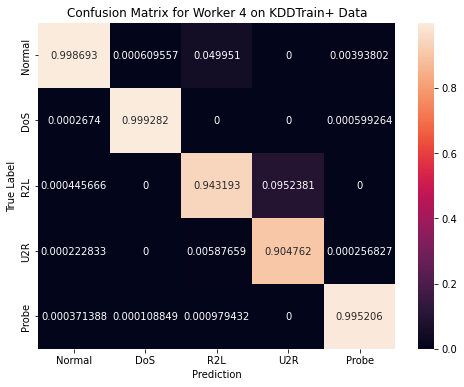

[output:0]

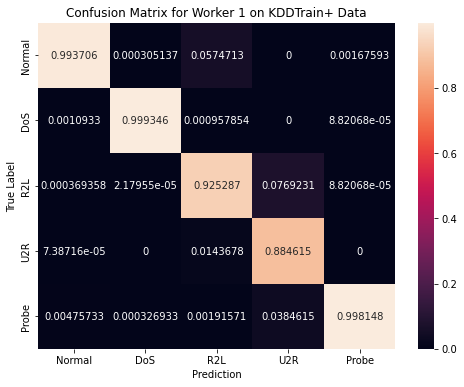

[output:1]

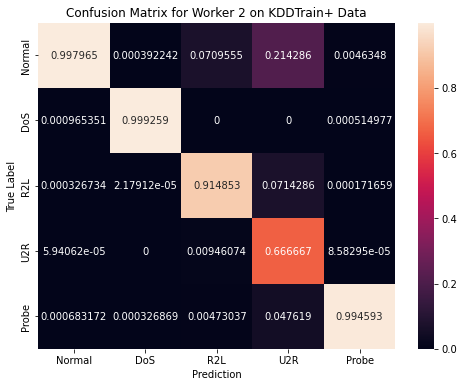

[output:2]

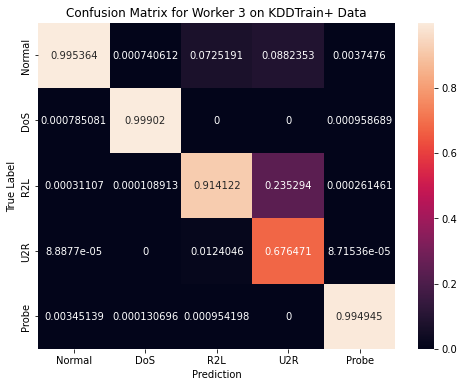

In [44]:
%%px --block
attack_labels = ['Normal','DoS','R2L', 'U2R','Probe']
plt.figure(figsize=(8, 6))
sns.heatmap(train_confusion_mtx,
            xticklabels=attack_labels,
            yticklabels=attack_labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Worker %d on KDDTrain+ Data' % (rank+1))
plt.show()

# Test Data Confusion Matrix

In [32]:
%%px --block
test_predictions = multi_model.predict(test_data)

[stdout:0] 705/705 [==============================] - 1s 1ms/step


[stdout:2] 705/705 [==============================] - 1s 1ms/step


[stdout:1] 705/705 [==============================] - 1s 1ms/step


[stdout:3] 705/705 [==============================] - 1s 1ms/step


In [33]:
%%px --block
pred = tf.math.argmax(test_predictions, axis=1)
test_confusion_mtx = tf.math.confusion_matrix(test_label_m, pred)
# normalize confusion matrix
test_confusion_mtx = test_confusion_mtx / tf.reduce_sum(test_confusion_mtx, 0).numpy()
test_confusion_mtx = tf.where(tf.math.is_nan(test_confusion_mtx), tf.zeros_like(test_confusion_mtx), test_confusion_mtx)

[output:0]

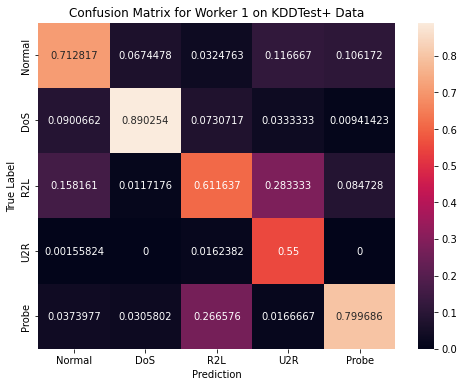

[output:3]

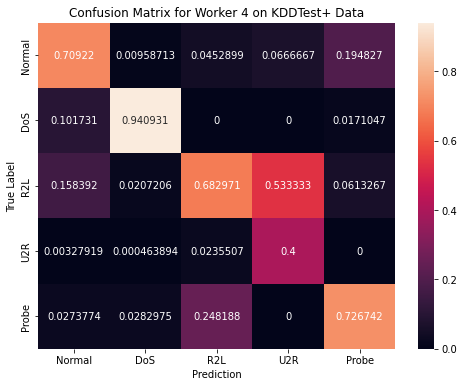

[output:1]

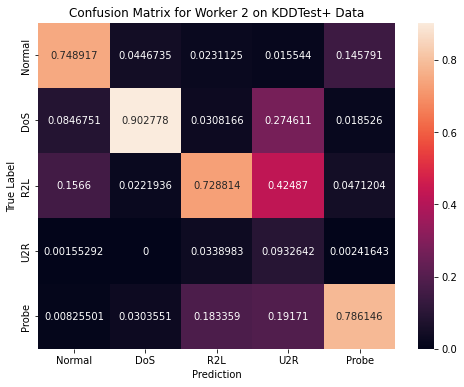

[output:2]

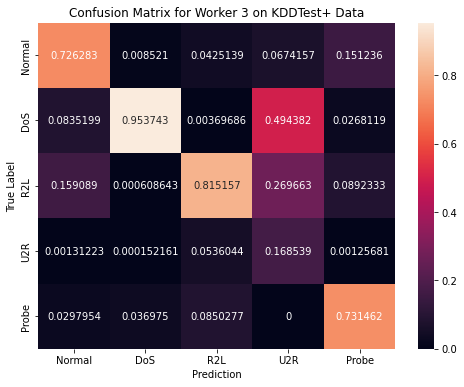

In [43]:
%%px --block
attack_labels = ['Normal','DoS','R2L', 'U2R','Probe']
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_mtx,
            xticklabels=attack_labels,
            yticklabels=attack_labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Worker %d on KDDTest+ Data' % (rank+1))
plt.show()